# Sensitivity Analysis

## 1. Define the problem and policies

In [52]:
# Imports

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, MultiprocessingEvaluator, perform_experiments, ema_logging, Policy, Scenario)
ema_logging.log_to_stderr(ema_logging.INFO)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging, save_results, load_results


from SALib.analyze import sobol
from plotting_for_sobol import plot_sobol_indices, plot_scores


In [15]:
# Specification of the problem

from problem_formulation import get_model_for_problem_formulation
dike_model, planning_steps = get_model_for_problem_formulation(1)

# Specification of the policies

policy_noaction = Policy("NoAction",  
                    **{'0_RfR 0': 0, '0_RfR 1' : 0, '0_RfR 2' : 0,
                    '1_RfR 0': 0, '1_RfR 1' : 0, '1_RfR 2' : 0,
                    '2_RfR 0': 0, '2_RfR 1' : 0, '2_RfR 2' : 0,
                    '3_RfR 0': 0, '3_RfR 1' : 0, '3_RfR 2' : 0,
                    '4_RfR 0': 0, '4_RfR 1' : 0, '4_RfR 2' : 0,
                    'A.1_DikeIncrease 0' : 0, 'A.1_DikeIncrease 1' : 0, 'A.1_DikeIncrease 2' : 0,
                    'A.2_DikeIncrease 0' : 0, 'A.2_DikeIncrease 1' : 0, 'A.2_DikeIncrease 2' : 0,
                    'A.3_DikeIncrease 0' : 0, 'A.3_DikeIncrease 1' : 0, 'A.3_DikeIncrease 2' : 0,
                    'A.4_DikeIncrease 0' : 0, 'A.4_DikeIncrease 1' : 0, 'A.4_DikeIncrease 2' : 0,
                    'A.5_DikeIncrease 0' : 0, 'A.5_DikeIncrease 1' : 0, 'A.5_DikeIncrease 2' : 0,
                    'EWS_DaysToThreat':  0   })

## 2. Sobol's scores

### 2.1 Execute Sensistivity Analysis on uncertainties

We will run a total of N(2K+2) = 10(2\*19+2) experiments, since the dike model has K=19 uncertainties and we use a baseline number of experiments equalling N=10

In [3]:
len(dike_model.uncertainties)

19

In [4]:
# Convert the problem into an SA-equivalent problem

sa_problem = get_SALib_problem(dike_model.uncertainties)

In [5]:
# Execute Sensistivity Analysis over uncertainties

baseline_n_experiments = 10
start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
     experiments, outcomes = evaluator.perform_experiments(scenarios = baseline_n_experiments,
                                                           policies = [policy_noaction], 
                                                           uncertainty_sampling = SOBOL)
end = time.time()
print('Sobol time is ' + str(round((end - start)/60)) + ' minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 400 scenarios * 1 policies * 1 model(s) = 400 experiments
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 280 cases completed
[MainProcess/INFO] 320 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
Sobol time is 7 minutes


In [6]:
# save the results

u_results = (experiments, outcomes)
save_results(u_results, '../results/Sobol_results_uncertainties_10ex_NoActionpol.tar.gz')

[MainProcess/INFO] results saved successfully to c:\Users\frac1\Documents\GitHub\Model Based DM - Assignment collaboration\model-based-decision-making\results\Sobol_results_uncertainties_10ex_NoActionpol.tar.gz


### 2.2 Execute Sensistivity Analysis on levers

We will run a sensitivity analysis over a total of N(2K+2) = 10(2\*31+2) experiments, since the dike model has K=31 levers and we use a baseline number of experiments equalling N=10 under the reference scenario (set as the worst-case scenario, and found from the notebook 1 - Reference Case Scenario)

In [7]:
len(dike_model.levers)

31

In [8]:
# Convert the problem into an SA-equivalent problem

sa_problem = get_SALib_problem(dike_model.levers)

In [9]:
# Load policy results of a NoAction policy under 500 scenarios (notebook 1-Reference Case Scenario)
[experiments, outcomes] = load_results("../results/500Scenarios_NoAction_PF1.tar.gz")
outcomes_df = pd.DataFrame(data=outcomes)

#Get index of worst-case scenario
index_wc = outcomes_df.sort_values("Expected Number of Deaths").tail(1).index
experiment_wc = experiments.iloc[index_wc]

#Set the reference scenario as the worst-case scenario
reference_scenarios = [Scenario(f"{index}", **row) for index, row in experiment_wc.iloc[0:,0:19].iterrows()]

[MainProcess/INFO] results loaded succesfully from c:\Users\frac1\Documents\GitHub\Model Based DM - Assignment collaboration\model-based-decision-making\results\500Scenarios_NoAction_PF1.tar.gz


In [10]:
# Execute Sensistivity Analysis over levers

baseline_n_experiments = 10

start = time.time()
with MultiprocessingEvaluator(dike_model) as evaluator:
     experiments, outcomes = evaluator.perform_experiments(scenarios = reference_scenarios,
                                                           policies = baseline_n_experiments,
                                                           levers_sampling = SOBOL)
end = time.time()
print('Sobol time is ' + str(round((end - start)/60)) + ' minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 640 policies * 1 model(s) = 640 experiments
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 128 cases completed
[MainProcess/INFO] 192 cases completed
[MainProcess/INFO] 256 cases completed
[MainProcess/INFO] 320 cases completed
[MainProcess/INFO] 384 cases completed
[MainProcess/INFO] 448 cases completed
[MainProcess/INFO] 512 cases completed
[MainProcess/INFO] 576 cases completed
[MainProcess/INFO] 640 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
Sobol time is 10 minutes


In [17]:
#save the results

l_results = (experiments, outcomes)
save_results(l_results, '../results/Sobol_results_levers_10ex_RefScenario.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\frac1\Documents\GitHub\Model Based DM - Assignment collaboration\model-based-decision-making\results\Sobol_results_levers_10ex_RefScenario.tar.gz


### 2.3 Calculate Sobol's scores

In [3]:
#load the levers' results

experiments, outcomes = load_results('../results/Sobol_results_levers_10ex_RefScenario.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\frac1\Documents\GitHub\Model Based DM - Assignment collaboration\model-based-decision-making\results\Sobol_results_levers_10ex_RefScenario.tar.gz


In [19]:
N = 10 #baseline_n_experiments
k = len(dike_model.levers) #number of levers

experiments, outcomes = l_results
policies = np.empty([len(experiments), 1])

kk = 0
l = N * (2*k+2)
for i in range (len(experiments)):
    policies[i] = kk
    if (i == l - 1) : 
        kk = kk + 1
        l = l + N * (2*k+2)
policies = policies.astype(int)

data = pd.DataFrame.from_dict(outcomes)
data['Policy'] = policies

outcomes_names = list(dike_model.outcomes.keys())
n_outcomes = len(outcomes_names)
len_outcomes = int(len(experiments) / 1)

outcomes_tup = ()

for i in range (0, n_outcomes) : 
    outcome_np = np.empty([len_outcomes, 1])
    for j in range(0, 1) : 
        outcome_np[:, j] = pd.DataFrame(data[data.Policy == j][outcomes_names[i]]).reset_index(drop = True).values[:, 0]
    outcomes_tup = outcomes_tup + (outcome_np,)

In [22]:
# Calculation of S1, S2, ST indices

problem = get_SALib_problem(dike_model.levers)
scores = []
for i in range(0, 1) : 
    scores.append(sobol.analyze(problem, outcomes_tup[0][:, i], calc_second_order=True))

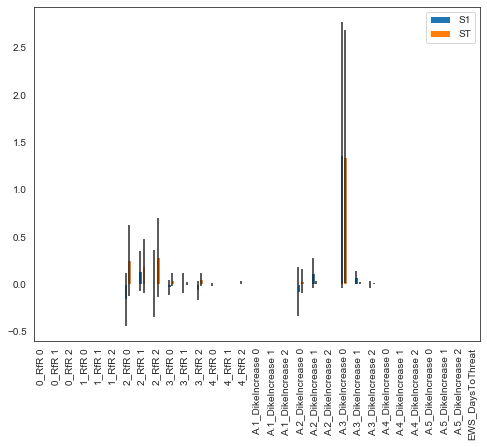

In [53]:
fig = plot_scores(scores[0], problem)
for i in range(1, 1) : 
    figi = plot_scores(scores[i], problem)
    figi.axes.append(fig)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'ix'

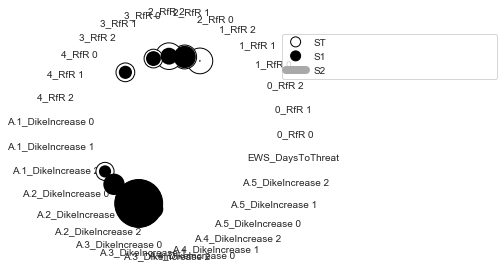

In [54]:
fig.set_size_inches(7,7)

figi = plot_sobol_indices(scores[0], problem, criterion='ST', threshold=0.005)
figi.set_size_inches(7,7)
figi.axes.append(fig)

plt.show()